In [1]:
# Persistent data I/O traffic distribution
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
%matplotlib inline

In [3]:
# Load persistent data I/O stats of queries
df = pd.read_parquet('~/snowflake-analysis/dataset_masked_v3.parquet', columns = ['persistentReadBytesCache', 
                                                                'persistentReadBytesS3', 
                                                                'persistentWriteBytesS3',
                                                               'persistentWriteBytesCache'],
                    engine='fastparquet')

In [6]:
# Filter out queries with zero persistent data I/O
df.query('persistentReadBytesCache + persistentReadBytesS3 + persistentWriteBytesS3 + persistentWriteBytesCache > 0',
        inplace=True)


In [8]:
df['totalPersistentIO'] = df['persistentReadBytesCache'] + df['persistentReadBytesS3'] + df['persistentWriteBytesCache'] + df['persistentWriteBytesS3']

In [13]:
# Calculate total amount of persistent data bytes read and written
df['persistentReadBytes'] = df['persistentReadBytesCache'] + df['persistentReadBytesS3']
# Cache is write-through
df['persistentWriteBytes'] = df['persistentWriteBytesS3'] 

# Assign query classes
df['ronly'] = (df['persistentWriteBytes'] == 0).astype('int')
df['wonly'] = (df['persistentReadBytes'] == 0).astype('int')
df['rw'] = ((df['persistentReadBytes'] > 0) & (df['persistentWriteBytes'] > 0)).astype('int')
df['qclass'] = df['ronly'] + df['wonly']*2 + df['rw']*3

In [16]:
# Sort queries within each class in descending order to total persistent data I/O
df.sort_values(by=['qclass', 'totalPersistentIO'], ascending=[True, False], inplace=True)

In [22]:
# Compute fractions of each component of persistent data I/O
fractions = df[['persistentReadBytesCache', 'persistentReadBytesS3','persistentWriteBytesCache', 'persistentWriteBytesS3']].div(df['totalPersistentIO'], axis=0).cumsum(axis=1).reset_index(drop=True)


In [49]:
# Downsample queries
fractions_sample = fractions.iloc[::5000, :].copy()
fractions_sample.reset_index(drop=True, inplace=True)



[0.0, 1358.1, 2716.2, 4074.2999999999997, 5432.4, 6790.5, 8148.599999999999, 9506.699999999999, 10864.8, 12222.9, 13581.0]


[Text(0, 0, '0.0'),
 Text(0, 0, '0.1'),
 Text(0, 0, '0.2'),
 Text(0, 0, '0.3'),
 Text(0, 0, '0.4'),
 Text(0, 0, '0.5'),
 Text(0, 0, '0.6'),
 Text(0, 0, '0.7'),
 Text(0, 0, '0.8'),
 Text(0, 0, '0.9'),
 Text(0, 0, '1.0')]

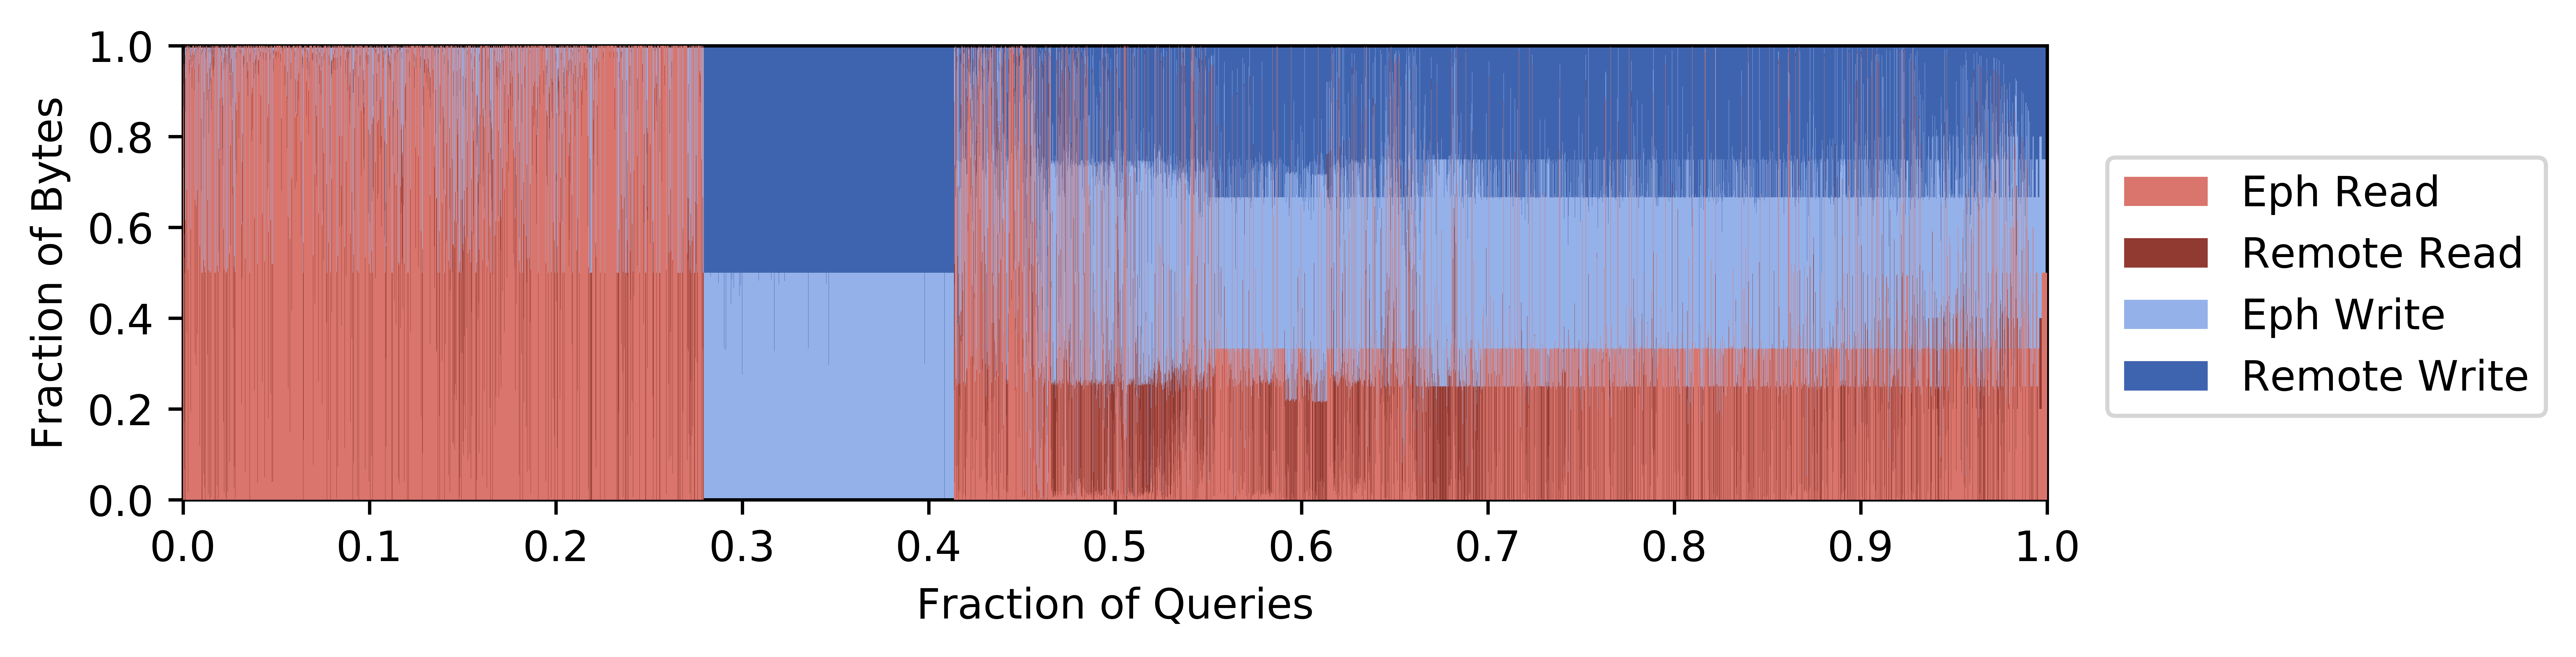

In [56]:
# Plot
width = 1
fig, ax2 = plt.subplots(figsize=(8,2), dpi=1000)
ax2.bar(fractions_sample.index, fractions_sample['persistentReadBytesCache'], width, color="#d9756c",label='Eph Read', zorder=4)
ax2.bar(fractions_sample.index, fractions_sample['persistentReadBytesS3'], width, color="#913a32", label='Remote Read', zorder=3)
ax2.bar(fractions_sample.index, fractions_sample['persistentWriteBytesCache'], width, color="#95b1e9", label='Eph Write', zorder=2)
ax2.bar(fractions_sample.index, fractions_sample['persistentWriteBytesS3'], width, color="#3f64af",label='Remote Write', zorder=1)

ax2.set_ylim([0, 1.0])
ax2.set_xlim([0, int(fractions_sample.count()[0])])
ax2.set_xlabel('Fraction of Queries')
ax2.set_ylabel('Fraction of Bytes')
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h2, l2, loc='upper center', bbox_to_anchor=(1.15, 0.8), ncol=1)

ticks = list(np.arange(0, int(fractions_sample.count()[0]) + 1, int(fractions_sample.count()[0])/10))
ax2.set_xticks(ticks)

a=ax2.get_xticks().tolist()
print(a)
a[0] = str(0.0)
a[1] = str(0.1)
a[2] = str(0.2)
a[3] = str(0.3)
a[4] = str(0.4)
a[5] = str(0.5)
a[6] = str(0.6)
a[7] = str(0.7)
a[8] = str(0.8)
a[9] = str(0.9)
a[10] = str(1.0)
# a[6] = str(1.0)
ax2.set_xticklabels(a)
